In [16]:
import numpy as np
import pandas as pd
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import Rbf

# Loading Dataset

In [2]:
df = pd.read_csv('/home/taha/Desktop/GaltonFamilies.csv')
df.head(10)

,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5
5,6,002,75.5,66.5,73.66,4,2,male,72.5
6,7,002,75.5,66.5,73.66,4,3,female,65.5
7,8,002,75.5,66.5,73.66,4,4,female,65.5
8,9,003,75.0,64.0,72.06,2,1,male,71.0
9,10,003,75.0,64.0,72.06,2,2,female,68.0


In [3]:
df = df.drop(columns=['family', 'rownames'])
conditions = [(df['gender'] == 'male'), (df['gender'] == 'female')]
labels = [0,1]
df['gender'] = np.select(conditions, labels)
df.head(5)

,father,mother,midparentHeight,children,childNum,gender,childHeight
0,78.5,67.0,75.43,4,1,0,73.2
1,78.5,67.0,75.43,4,2,1,69.2
2,78.5,67.0,75.43,4,3,1,69.0
3,78.5,67.0,75.43,4,4,1,69.0
4,75.5,66.5,73.66,4,1,0,73.5


In [4]:
len(df)

934

<Axes: >

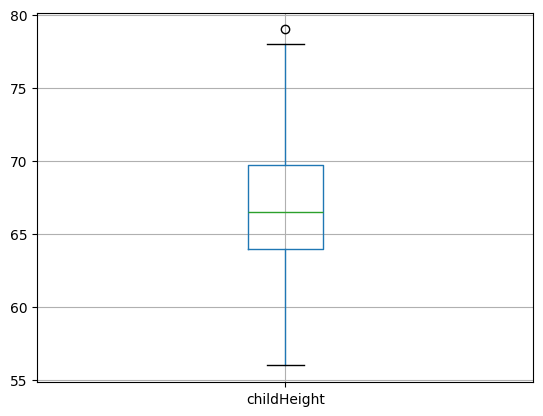

In [5]:
df.boxplot(column='childHeight')

In [6]:
conditions = [(df['childHeight'] < 64), (df['childHeight'] >= 64) & (df['childHeight'] <=69),(df['childHeight'] > 69)]
labels = [0, 1, 2]
df['childHeight'] = np.select(conditions, labels)
df.head(5)

,father,mother,midparentHeight,children,childNum,gender,childHeight
0,78.5,67.0,75.43,4,1,0,2
1,78.5,67.0,75.43,4,2,1,2
2,78.5,67.0,75.43,4,3,1,1
3,78.5,67.0,75.43,4,4,1,1
4,75.5,66.5,73.66,4,1,0,2


# MLP

In [9]:
data_df = df.drop(columns = ['childHeight'])
target_df = df['childHeight']
train_data, test_data, train_target, test_target = train_test_split(data_df, target_df, test_size=0.25)

In [11]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), 
    activation='relu',           
    solver='adam',                
    max_iter=100,                
    random_state=42
)

mlp.fit(train_data, train_target)

train_acc_mlp = mlp.score(train_data, train_target)
test_acc_mlp = mlp.score(test_data, test_target)
print("Train accuracy:", train_acc_mlp)
print("Test accuracy:", test_acc_mlp)

Train accuracy: 0.7957142857142857
Test accuracy: 0.6837606837606838


/home/taha/Desktop/cnnn/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


# Multiquadric RBF Interpolation

In [17]:
def interpolation(input, n, rbf_function):
    new_rows = []
    for i in range(len(input) - 1):
        x1, x2 = input[i], input[i+1]
        steps = np.linspace(0, 1, n + 2)[1:-1]
        for step in steps:
            interpolated_list = []
            for feature in range(input.shape[1]):
                rbf = Rbf([0,1], [x1[feature], x2[feature]], function = rbf_function)
                interpolated_list.append(rbf(step))
            new_rows.append(interpolated_list)
    return np.array(new_rows)

In [19]:
input = df.values
synthetic_data = interpolation(input, 10, 'multiquadric')

In [20]:
augmented_data = np.vstack([input, synthetic_data])
df_multiquadric = pd.DataFrame(augmented_data, columns = ['father', 'mother', 'midparentHeight', 'children', 'childNum', 'gender', 'childHeight'])
print(f"The new dataframe has {len(df_multiquadric)} rows.")

The new dataframe has 10264 rows.


In [25]:
data_df = df_multiquadric.drop(columns = ['childHeight'])
target_df = df_multiquadric['childHeight']
target_df = np.rint(target_df).astype(int)
train_data, test_data, train_target, test_target = train_test_split(data_df, target_df, test_size=0.25)

In [28]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), 
    activation='relu',           
    solver='adam',                
    max_iter=100,                
    random_state=42
)

mlp.fit(train_data, train_target)

train_acc_mq_mlp = mlp.score(train_data, train_target)
train_acc_mq_mlp = mlp.score(test_data, test_target)
print("Train accuracy:", train_acc_mq_mlp)
print("Test accuracy:", train_acc_mq_mlp)

Train accuracy: 0.7404520654715511
Test accuracy: 0.7404520654715511


/home/taha/Desktop/cnnn/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
